## Transfer learning : Fine-tuning

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import optimizers
from keras import losses
from keras import activations
from keras import callbacks
from keras import utils
from keras import metrics
from keras import applications
from keras import regularizers
from keras import preprocessing 

from keras import datasets

from keras import mixed_precision

mixed_precision.set_global_policy('mixed_float16')

In [2]:
mixed_precision.global_policy()

<DTypePolicy "mixed_float16">

In [3]:
!nvidia-smi -L


GPU 0: NVIDIA GeForce GTX 1650 (UUID: GPU-72ac3021-d1f7-0394-e845-34821fc5a1c7)


### *Get the data*

In [3]:
# import zipfile

# # Download data
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# # Unzip the  downloaded file
# zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
# zip_ref.extractall()
# zip_ref.close()

In [4]:
# How many images in each folder?
import os

# Walk through 10 percent data directories and list the number of files
for dirpath, dirname, filename in os.walk("10_food_classes_10_percent"):
    print(f"There'are {len(dirname)} directories and {len(filename)} images in '{dirpath}'")


There'are 2 directories and 0 images in '10_food_classes_10_percent'
There'are 10 directories and 0 images in '10_food_classes_10_percent/test'
There'are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'
There'are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'
There'are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'
There'are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'
There'are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'
There'are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'
There'are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'
There'are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'
There'are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'
There'are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi

### *Creating data loaders (preparing the data)*

In [5]:
Image_shape  = (224, 224)
Batch_size = 32
c_mode = "categorical"

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

# Create data inputs
import tensorflow as tf
IMG_SIZE = (224, 224) # define image size
train_data_10_percent = preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical", # what type are the labels?
                                                                            batch_size=32) # batch_size is 32 by default, this is generally a good number

test_data_10_percent = preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical")





Found 750 files belonging to 10 classes.


I0000 00:00:1738672054.190138    9365 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2795 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


Found 2500 files belonging to 10 classes.


In [6]:
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [7]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [8]:
# See an example batch of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[1.17448978e+01 5.15816307e+00 1.12755098e+01]
   [1.34642849e+01 1.25867348e+01 2.87754965e+00]
   [1.18367398e+00 6.25000095e+00 2.31122589e+00]
   ...
   [2.70867119e+01 1.81428356e+01 1.40153484e+01]
   [1.63877602e+01 1.16224976e+01 7.47962713e+00]
   [1.79438648e+01 1.78878002e+01 1.15867567e+01]]

  [[1.33826532e+01 7.12244940e+00 1.03775511e+01]
   [3.87602081e+01 3.55561218e+01 2.68877563e+01]
   [1.09438763e+01 1.26275511e+01 5.22448969e+00]
   ...
   [1.76122475e+01 1.23418818e+01 0.00000000e+00]
   [2.15510292e+01 1.84898205e+01 3.97964048e+00]
   [1.48365650e+01 1.57702465e+01 2.38762569e+00]]

  [[1.38469391e+01 1.04183674e+01 4.89796281e-01]
   [4.03520470e+01 3.40510254e+01 2.40408211e+01]
   [8.59693909e+00 4.71428680e+00 1.74489880e+00]
   ...
   [4.27804222e+01 3.99028587e+01 3.36700380e-01]
   [2.55611420e+01 2.22907639e+01 0.00000000e+00]
   [1.86275272e+01 1.81377811e+01 0.00000000e+00]]

  ...

  [[2.03673878e+01 1.02245140e+01 5.29082823e+00]
   [2

2025-02-04 19:27:36.395782: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### *EfficientNetV250*

In [33]:
# 1.Create base model with tf.keras.applications
base_model = applications.ResNet50V2()

# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# 3. Create inputs into our model
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNet50V2 you will need to normalize inputs (you don't have to for EfficientNet(s))
# x = keras.preprocessing.Rescaling(1./255)(x)

# 5. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNet inputs don't have to be normalized)
x = base_model(inputs)

# check the shape of the output of the base model
print("Shape after base_model:", x.shape) # x is the output of the EfficientNetB0 base model

# # 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
# x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
# print("Output shape after GlobalAveragePooling2D:", x.shape)

# 7. Create the output activation layer
outputs = layers.Dense(10, activation=activations.softmax, name="output_layer")(x)
outputs_ = layers.Dense(10, activation=activations.softmax, name="output_layer_")(outputs)

# 8. Combine the inputs with the outputs into a model
model = keras.Model(inputs, outputs_)

# 9. Compile the model
model.compile(loss=losses.categorical_crossentropy,
              optimizer=optimizers.Adam(),
              metrics=[metrics.categorical_accuracy])




Shape after base_model: (None, 1000)


In [34]:
# 10. Fit the model
efficientnet_history = model.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data_10_percent,
                                 validation_steps=int(0.25 * len(test_data_10_percent)),
                                #  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                #                                         experiment_name="efficientnetb0")]
                                )

Epoch 1/5


E0000 00:00:1738672907.491968    9574 cuda_dnn.cc:522] Loaded runtime CuDNN library: 9.1.0 but source was compiled with: 9.3.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
E0000 00:00:1738672907.590108    9574 cuda_dnn.cc:522] Loaded runtime CuDNN library: 9.1.0 but source was compiled with: 9.3.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
2025-02-04 19:41:47.620493: W tensorflow/core/framework/op_kernel.cc:1841] OP_REQUIRES failed at xla_ops.cc:577 : FAILED_PRECONDITION: DNN library initialization failed. Look at the er

FailedPreconditionError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/lovecrush/miniconda3/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/lovecrush/miniconda3/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/lovecrush/miniconda3/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/lovecrush/miniconda3/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/home/lovecrush/miniconda3/lib/python3.12/asyncio/base_events.py", line 639, in run_forever

  File "/home/lovecrush/miniconda3/lib/python3.12/asyncio/base_events.py", line 1985, in _run_once

  File "/home/lovecrush/miniconda3/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/home/lovecrush/miniconda3/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/lovecrush/miniconda3/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/lovecrush/miniconda3/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/lovecrush/miniconda3/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/lovecrush/miniconda3/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/lovecrush/miniconda3/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/lovecrush/miniconda3/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/lovecrush/miniconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/lovecrush/miniconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/lovecrush/miniconda3/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/lovecrush/miniconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/lovecrush/miniconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/lovecrush/miniconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_9365/2487164843.py", line 2, in <module>

  File "/home/lovecrush/miniconda3/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/lovecrush/miniconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 320, in fit

  File "/home/lovecrush/miniconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

DNN library initialization failed. Look at the errors above for more details.
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_one_step_on_iterator_70080]

In [13]:
# Check layer in the base model
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name)

0 input_layer
1 rescaling
2 normalization
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_conv
47 b

In [14]:
base_model.summary()

Model: "efficientnetv2-b0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, None,      │          0 │ input_layer[0][0] │
│ (Rescaling)         │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, None,      │          0 │ rescaling[0][0]   │
│ (Normalization)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, None,      │        864 │ normalization[0]… │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, None,      │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, None,      │          0 │ stem_bn[0][0]     │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, None,      │      4,608 │ stem_activation[… │
│ (Conv2D)            │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, None,      │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, None,      │          0 │ block1a_project_… │
│ (Activation)        │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, None,      │      9,216 │ block1a_project_… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, None,      │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, None,      │          0 │ block2a_expand_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, None,      │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, None,      │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, None,      │     36,864 │ block2a_project_… │
│ (Conv2D)            │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, None,      │        512 │ block2b_expand_c… │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_act… │ (None, None,      │          0 │ block2b_expand_b

 Total params: 5,919,312 (22.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 5,919,312 (22.58 MB)

In [15]:
# Check layer in the base model
for layer_number, layer in enumerate(model.layers):
    print(layer_number, layer.name)

0 input_layer
1 efficientnetv2-b0
2 global_average_pooling_layer
3 output_layer
4 output_layer_


In [16]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │        12,810 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer_ (Dense)           │ (None, 10)             │           110 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,932,232 (22.63 MB)

 Trainable params: 12,920 (50.47 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

### *Getting the feature vector from the trained model*

In [17]:
# Define input tensor shape (same number of dimensions as the output of efficientnetv2-b0)
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shapes of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of 2D global averaged pooled input tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of 2D global averaged pooled input tensor: (1, 3)


In [18]:
# This is the same as GlobalAveragePooling2D()
tf.reduce_mean(input_tensor, axis=[1, 2]) # average across the middle axes

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

In [23]:
# New: newer versions of tensorflow (2.10+) can use the tensorflow.keras.layer.api directly for data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),    
], name="data_augmentation")



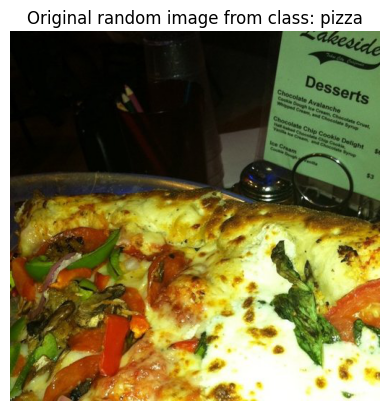

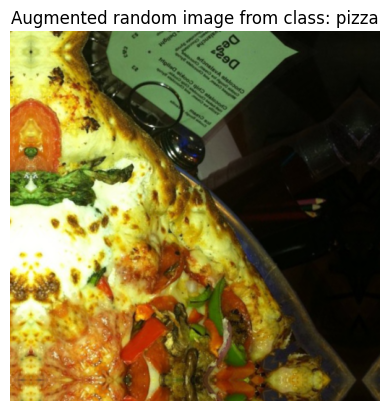

In [25]:
# View a random image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_10_percent.class_names) # choose a random class
target_dir = "10_food_classes_10_percent/train/" + target_class # create the target directory
random_image = random.choice(os.listdir(target_dir)) # choose a random image from target directory
random_image_path = target_dir + "/" + random_image # create the choosen random image path
img = mpimg.imread(random_image_path) # read in the chosen target image
plt.imshow(img) # plot the target image
plt.title(f"Original random image from class: {target_class}")
plt.axis(False); # turn off the axes

# Augment the image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0)) # data augmentation model requires shape (None, height, width, 3)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) # requires normalization after augmentation
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

In [28]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model with inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                    epochs=5,
                    steps_per_epoch=len(train_data_1_percent),
                    validation_data=test_data,
                    validation_steps=int(0.25* len(test_data)), # validate for less steps
                    # Track model training logs
                    callbacks=[create_tensorboard_callback("transfer_learning", "1_percent_data_aug")])

ValueError: A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.operations`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```


## Tensorflow test code